# **Volatility Forecasting using the GARCH Statistical Model**

This notebook presents a comprehensive analysis and forecasting framework for modeling the volatility of Tesla (TSLA) stock returns using GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models.

The workflow includes:
*   Data acquisition using yfinance and computation of daily log returns.
*   Exploratory Data Analysis (EDA) to assess distributional characteristics, volatility clustering, and autocorrelation structures (via ACF/PACF plots and squared returns).
*   Stationarity testing with both ADF and KPSS tests to validate model assumptions.
*   Baseline GARCH(1,1) modeling, including coefficient interpretation and diagnostics (residuals, standardized residuals, Ljung-Box test).
*   Multi-model evaluation, comparing GARCH variants (1,1), (1,2), (2,1), and (2,2) using AIC/BIC to identify the most parsimonious fit.
*   Short-horizon (60-day) volatility forecasts using the best model, compared against 30-day rolling realized volatility.
*   Rolling 1-day-ahead forecasts with a 250-day training window to mimic real-world use cases, plotted against realized volatility for out-of-sample performance analysis.   

The project shows strong evidence of volatility clustering in TSLA returns and demonstrates how GARCH models — particularly GARCH(1,1) — can effectively forecast periods of market turbulence or calm. The notebook also sets the stage for future work with asymmetric GARCH models and multi-factor volatility modeling using exogenous variables.

## Part 1 - Setup and Data Collection

In [1]:
!pip install yfinance arch

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 7.0 MB/s eta 0:00:00


In [2]:
# Retrieve TSLA stock data and compute daily log returns
tsla_stock = yf.download('TSLA', start='2015-01-01', end='2023-12-31')
tsla_stock['Log Returns'] = np.log(tsla_stock['Close'] / tsla_stock['Close'].shift(1))
tsla_returns = tsla_stock['Log Returns'].dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Part 2 - Exploratory Data Analysis

In the following cell, we visualize the daily log returns of TSLA, allowing us to determine volatility clustering visually.

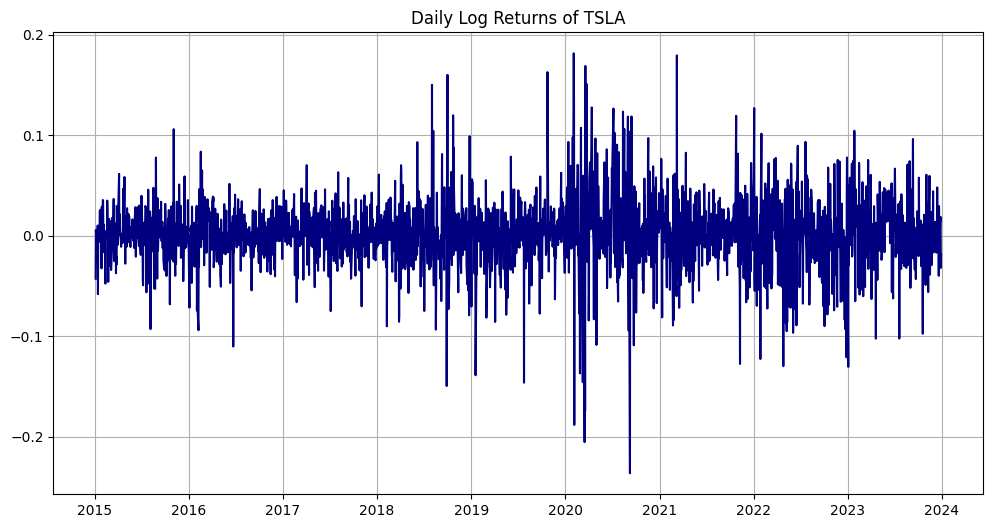

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(tsla_returns, color="navy")
plt.title(f'Daily Log Returns of TSLA')
plt.grid(True)
plt.show()

In the following code cells, we perform the following EDA methods:
*   Histogram and kernel density estimate (KDE) plot
*   Boxplot (to detect outliers)
*   Computing rolling statistics (i.e., mean and std dev)
*   Generating ACF and PACF plots
*   ACF of Squared Returns (this is a check for volatility clustering)
*   Summary statistics




The histogram and KDE plot helps us understand the distribution of daily log returns data better, as well as its skew and kurtosis.

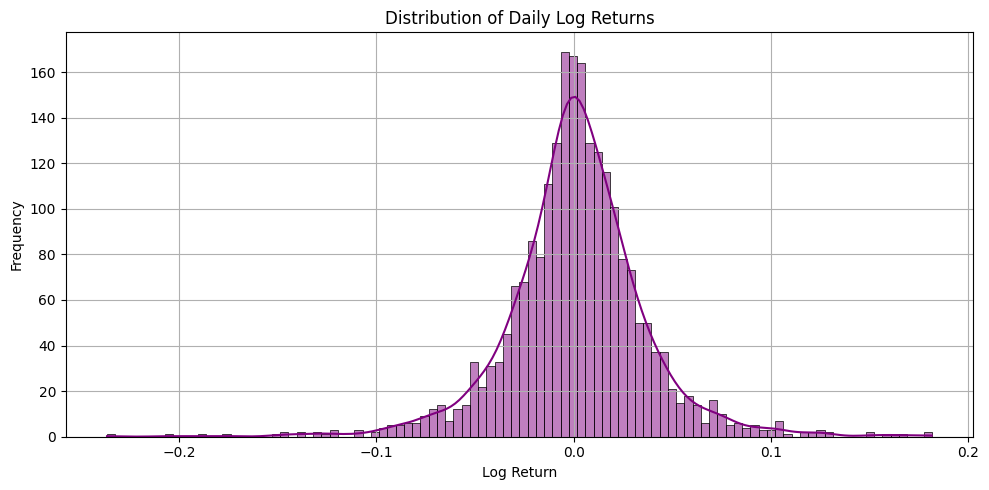

In [4]:
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 5))
sns.histplot(tsla_returns, bins=100, kde=True, color='purple')
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

The boxplot shown below allows us to determine outliers within the data easily.

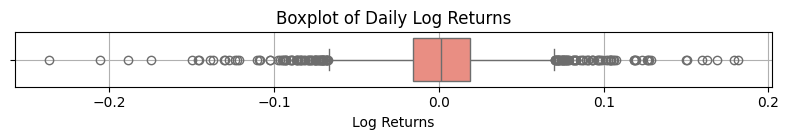

In [5]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(data=tsla_returns, orient='h', color='salmon')
plt.title("Boxplot of Daily Log Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

Computing rolling mean and standard deviation is useful for determining how volatility varies over time.

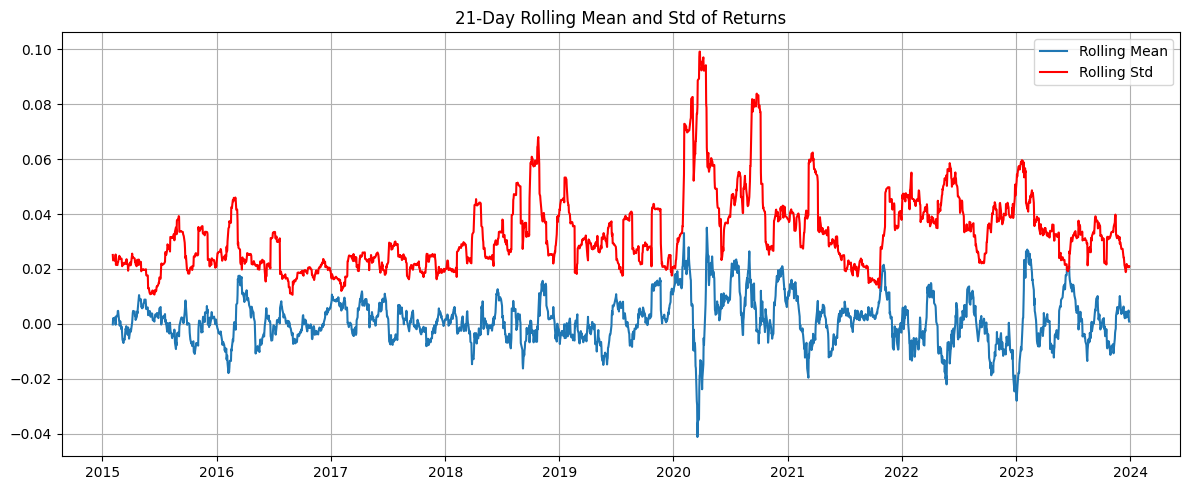

In [6]:
rolling_window = 21
rolling_mean = tsla_returns.rolling(window=rolling_window).mean()
rolling_std = tsla_returns.rolling(window=rolling_window).std()

plt.figure(figsize=(12, 5))
plt.plot(rolling_mean, label="Rolling Mean")
plt.plot(rolling_std, label="Rolling Std", color='red')
plt.title(f"{rolling_window}-Day Rolling Mean and Std of Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ACF and PACF plots inform autocorrelation structure (i.e., how a time series data point relates to its previous values) and is useful for model lag order selection.

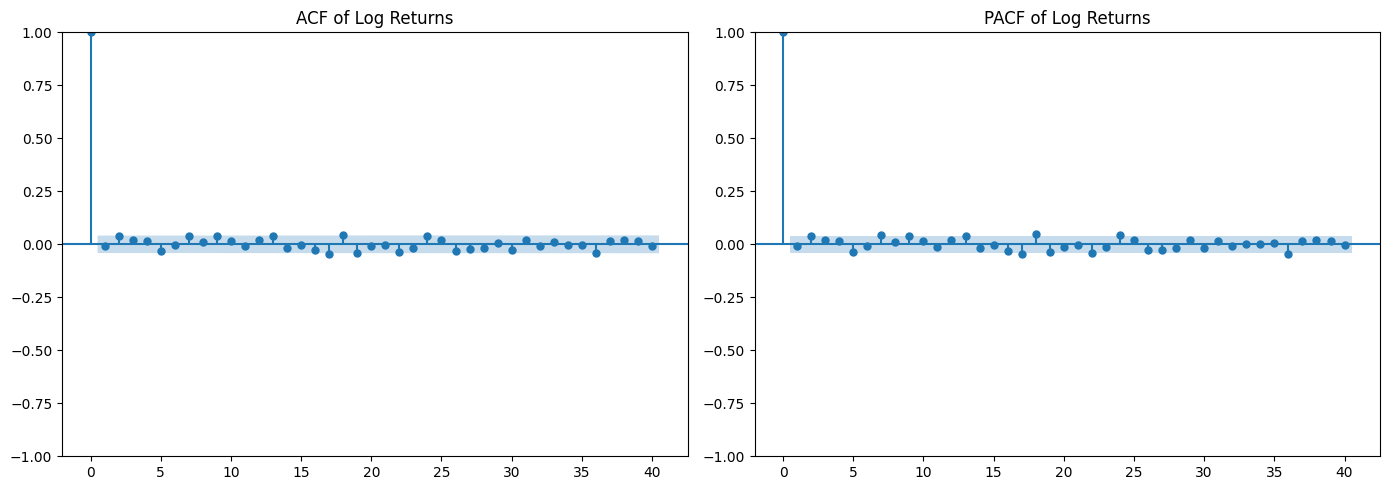

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(tsla_returns, lags=40, ax=axs[0])
axs[0].set_title("ACF of Log Returns")
plot_pacf(tsla_returns, lags=40, ax=axs[1])
axs[1].set_title("PACF of Log Returns")
plt.tight_layout()
plt.show()

The ACF of squared returns plot is a test to determine the presence of *conditional heteroskedasticity* (CH), which is when the variance of the error term in a regression model is not constant, but rather depends on values of either independent variables from data or the data's error terms themselves. If the time series data demonstrates CH, that implies GARCH is necessary for accurate volatility clustering.

<Figure size 700x400 with 0 Axes>

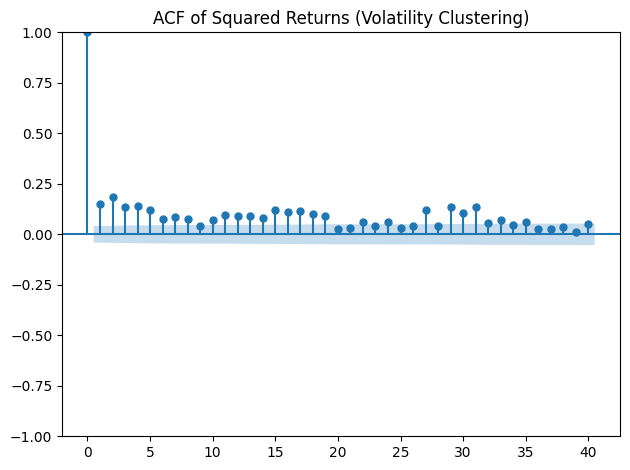

In [8]:
plt.figure(figsize=(7, 4))
plot_acf(tsla_returns**2, lags=40)
plt.title("ACF of Squared Returns (Volatility Clustering)")
plt.tight_layout()
plt.show()

Finally, we capture the summary statistics to get high-level information of the time-series data themselves.

In [9]:
print("Summary Statistics:")
print(f"Mean:     {tsla_returns.mean():.6f}")
print(f"Std Dev:  {tsla_returns.std():.6f}")
print(f"Skewness: {skew(tsla_returns):.4f}")
print(f"Kurtosis: {kurtosis(tsla_returns):.4f}")
jb_stat, jb_p = jarque_bera(tsla_returns)
print(f"Jarque-Bera Test Statistic: {jb_stat:.2f} | p-value: {jb_p:.4f}")

Summary Statistics:
Mean:     0.001252
Std Dev:  0.035513
Skewness: -0.1632
Kurtosis: 4.5046
Jarque-Bera Test Statistic: 1923.37 | p-value: 0.0000


## Part 3 - Stationarity Tests and Model Building

In this section, we first evaluate whether our log return time series is stationary, a key assumption for GARCH models. To do this robustly, we use two complementary statistical tests:

1. **Augmented Dickey-Fuller (ADF) Test**
*   Null Hypothesis (H₀): The series has a unit root → non-stationary
*   Alternative Hypothesis (H₁): The series is stationary

If the p-value is less than 0.05, we reject the null and conclude the series is likely stationary.

2. **Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test**
*   Null Hypothesis (H₀): The series is trend-stationary (stationary around a deterministic trend)
*   Alternative Hypothesis (H₁): The series has a unit root → non-stationary

Unlike the ADF, the KPSS test flips the hypotheses, treating stationarity as the null. If the p-value is less than 0.05, we reject the null and conclude that the series is likely non-stationary.

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series, title='ADF Test'):
    print(f'\n{title}')
    result = adfuller(series, autolag='AIC')
    print(f'Test Statistic : {result[0]:.4f}')
    print(f'p-value        : {result[1]:.4f}')
    print(f'# Lags Used    : {result[2]}')
    print(f'# Observations : {result[3]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value:.4f}')
    if result[1] < 0.05:
        print("=> Reject the null hypothesis (stationary)")
    else:
        print("=> Fail to reject the null hypothesis (non-stationary)")

def kpss_test(series, title='KPSS Test'):
    print(f'\n{title}')
    result = kpss(series, regression='c', nlags="auto")
    print(f'Test Statistic : {result[0]:.4f}')
    print(f'p-value        : {result[1]:.4f}')
    print(f'# Lags Used    : {result[2]}')
    for key, value in result[3].items():
        print(f'Critical Value {key}: {value:.4f}')
    if result[1] < 0.05:
        print("=> Reject the null hypothesis (non-stationary)")
    else:
        print("=> Fail to reject the null hypothesis (stationary)")

adf_test(tsla_returns, title='ADF Test on Log Returns')
kpss_test(tsla_returns, title='KPSS Test on Log Returns')


ADF Test on Log Returns
Test Statistic : -32.4782
p-value        : 0.0000
# Lags Used    : 1
# Observations : 2261
Critical Value 1%: -3.4332
Critical Value 5%: -2.8628
Critical Value 10%: -2.5675
=> Reject the null hypothesis (stationary)

KPSS Test on Log Returns
Test Statistic : 0.1540
p-value        : 0.1000
# Lags Used    : 1
Critical Value 10%: 0.3470
Critical Value 5%: 0.4630
Critical Value 2.5%: 0.5740
Critical Value 1%: 0.7390
=> Fail to reject the null hypothesis (stationary)


<ipython-input-10-a2ad233e36be>:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")


Now that we have performed stationarity testing (and determined that the TSLA daily log returns dataset is indeed stationary), we can proceed with building and eventually fitting the desired GARCH model.

To clarify, a GARCH(1, 1) volatility model is defined such that today's variance depends on yesterday's squared returns and yesterday's variance.

In [11]:
# First model to test - a basic GARCH(1, 1) model on TSLA daily log returns
garch11 = arch_model(tsla_returns, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
garch11_fit = garch11.fit(disp='off')
print(garch11_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4519.99
Distribution:                  Normal   AIC:                          -9033.99
Method:            Maximum Likelihood   BIC:                          -9016.82
                                        No. Observations:                 2263
Date:                Tue, Apr 15 2025   Df Residuals:                     2263
Time:                        20:25:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5243e-05  2.148e-06     11.749  7.110e-32 [2.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


A zero mean model assumes that the return series has zero mean (which is appropriate for return data after demeaning.) Additionally, the distribution being normal implies that the model's residuals are assumed to be normally distributed.

Omega represents the long-run average variance, or the "baseline volatility level."

Alpha[1] represents the reaction of volatility to recent shocks (i.e., lagged squared returns), while beta[1] corresponds to the persistence of past volatility (lagged conditional variance.)

From the above fitted model summary, we can determine the following:
*   Because the sum of alpha[1] and beta[1] is approximately 1 (0.98), we can deduce that the volatility process is highly persistent - meaning that past volatility tends to influence the presence of future volatility. **This confirms the presence of volatility clustering.**
*   Shocks decay slowly (which is common in financial time series data like stock returns.)
*   The model can be characterized as well-behaved because its coefficients are all statistically significant (i.e., their P>|t| values are all very low.)

Next, we perform "model diagnostics" (i.e., plotting the model's residuals and standardized residuals.)

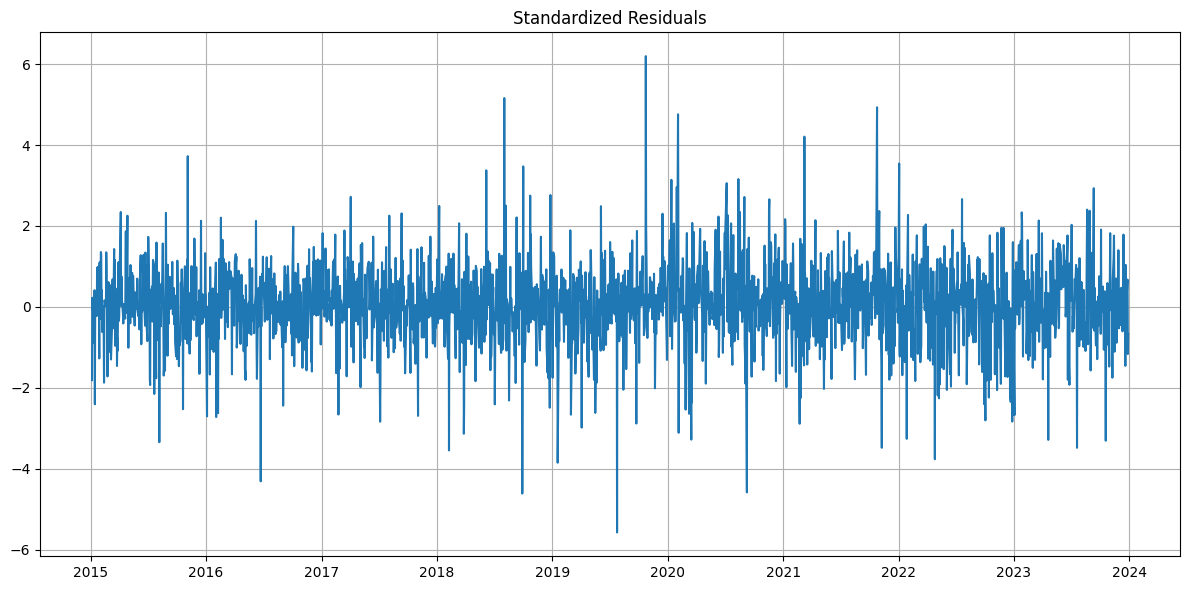

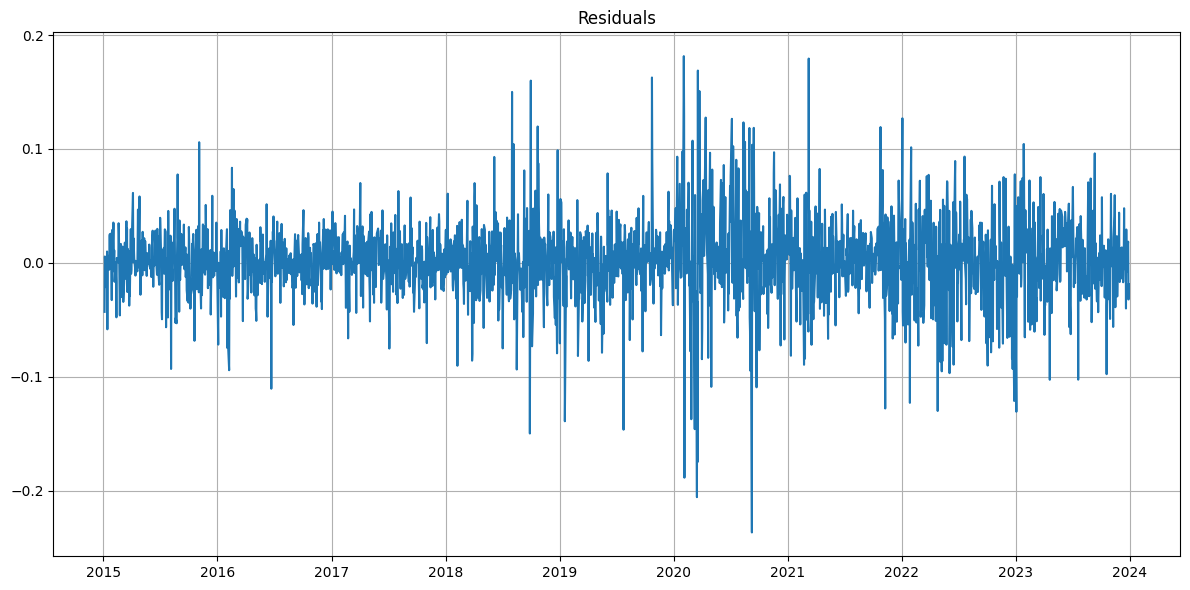

In [12]:
resid = garch11_fit.resid
std_resid = resid / garch11_fit.conditional_volatility

plt.figure(figsize=(12, 6))
plt.plot(std_resid)
plt.title("Standardized Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(resid)
plt.title("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

Residuals, at a high level, are the difference between the observed returns and a model's conditional mean.

Standardized residuals essentially normalize the residuals using the model's forecasted volatility (similar to z-scoring.)

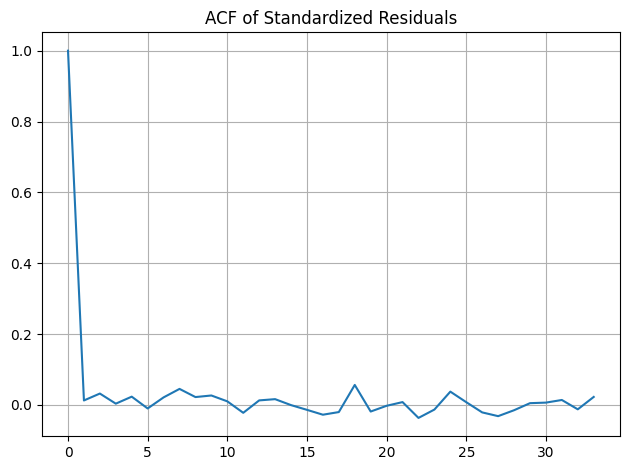

In [13]:
from statsmodels.tsa.stattools import acf

std_resid_acf_values = acf(std_resid)
plt.plot(std_resid_acf_values)
plt.title("ACF of Standardized Residuals")
plt.tight_layout()
plt.grid(True)
plt.show()

Finally, we will perform the Ljung-Box test, which checks whether there is autocorrelation in a time series up to a certain number of lags. Specifically, the test is applied to standardized residuals to determine if any linear autocorrelation is remaining, and to squared standardized residuals to determine if any ARCH effects are remaining.

*ARCH effects* refer to time-dependent volatility. If past squared residuals can predict current variance, you have ARCH effects.

In [14]:
# Perform the Ljung-Box test to check for any remaining ARCH effects
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(std_resid ** 2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.745433,0.749239


Because of the significantly large p-value, we know that our GARCH model has explained volatility well.

## Part 4 - Model Evaluation

Performing forecasting with initial GARCH(1,1) model:

In [19]:
# Forecasting volatility
forecast_horizon = 60
forecast = garch11_fit.forecast(horizon=forecast_horizon)

# Extracting the forecasted variance
variance_forecast = forecast.variance[-1:]
vol_forecast = np.sqrt(variance_forecast.T)
print(vol_forecast)

Date  2023-12-29
h.01    0.027739
h.02    0.027916
h.03    0.028088
h.04    0.028256
h.05    0.028420
h.06    0.028579
h.07    0.028735
h.08    0.028886
h.09    0.029034
h.10    0.029178
h.11    0.029318
h.12    0.029455
h.13    0.029589
h.14    0.029719
h.15    0.029847
h.16    0.029971
h.17    0.030092
h.18    0.030210
h.19    0.030326
h.20    0.030438
h.21    0.030548
h.22    0.030656
h.23    0.030761
h.24    0.030863
h.25    0.030964
h.26    0.031061
h.27    0.031157
h.28    0.031250
h.29    0.031342
h.30    0.031431
h.31    0.031518
h.32    0.031603
h.33    0.031686
h.34    0.031768
h.35    0.031847
h.36    0.031925
h.37    0.032001
h.38    0.032075
h.39    0.032148
h.40    0.032219
h.41    0.032289
h.42    0.032356
h.43    0.032423
h.44    0.032488
h.45    0.032551
h.46    0.032614
h.47    0.032674
h.48    0.032734
h.49    0.032792
h.50    0.032849
h.51    0.032905
h.52    0.032959
h.53    0.033013
h.54    0.033065
h.55    0.033116
h.56    0.033166
h.57    0.033215
h.58    0.0332

Here, vol_forecast represents the square root of the predicted variance (i.e., the forecasted volatility) for the next 30 days starting from the last available date in the training set.

These are *annualized standard deviations of return*; if returns are daily log returns, the values above are in units of daily volatility.

In [20]:
last_date = tsla_returns.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
print(forecast_dates)

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22',
               '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26',
               '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01',
               '2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07',
               '2024-02-08', '2024-02-09', '2024-02-12', '2024-02-13',
               '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-19',
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
               '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18',
      

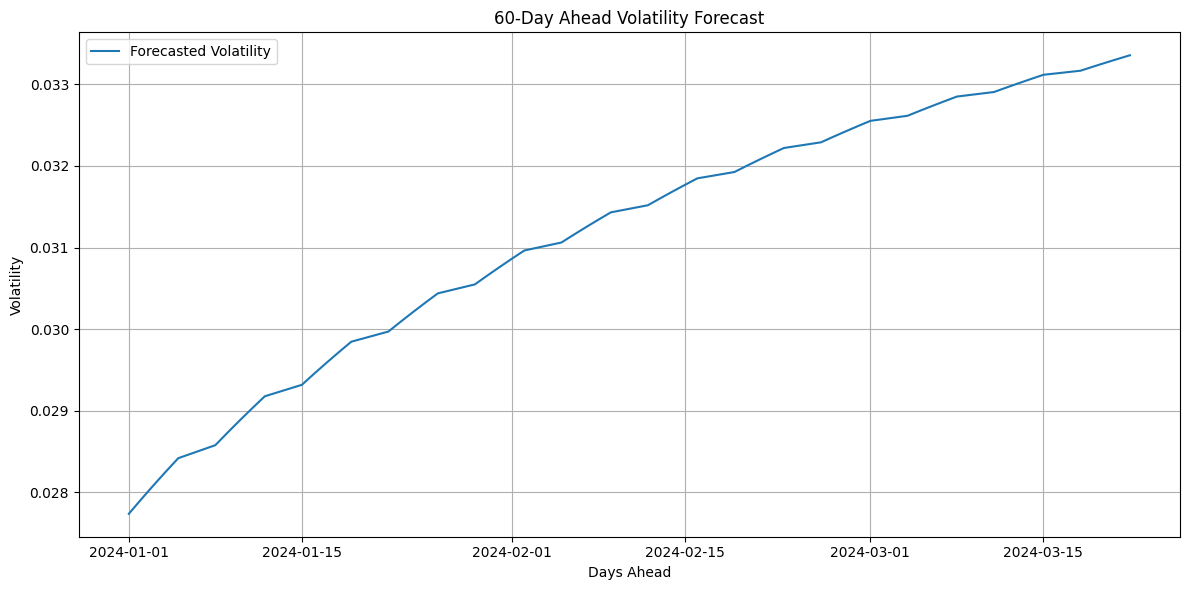

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, vol_forecast.values.T[0], label="Forecasted Volatility")
plt.title("60-Day Ahead Volatility Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

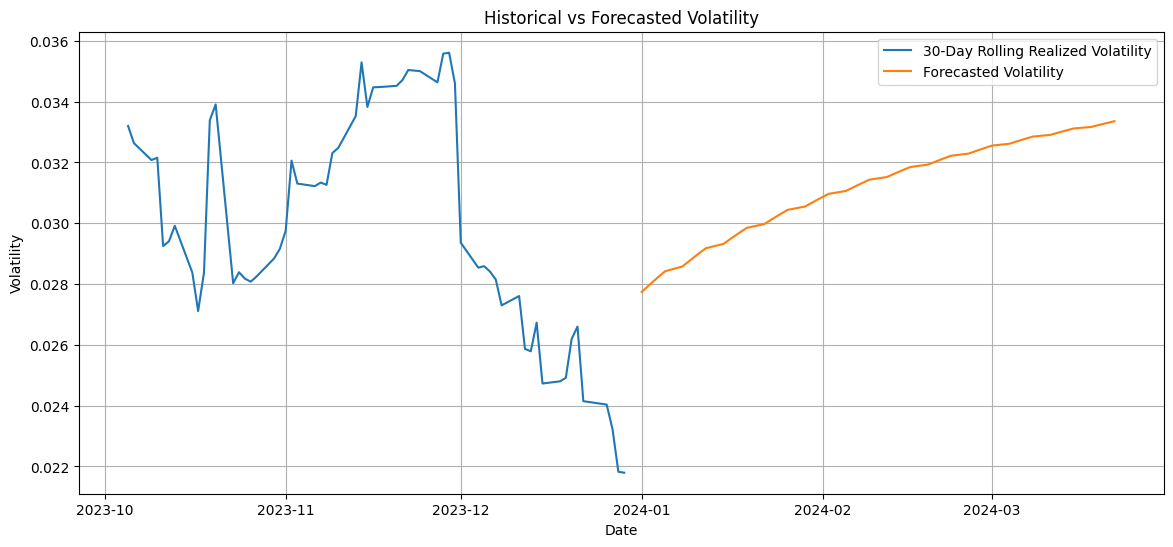

In [23]:
# Comparing the historical realized volatility with the forecasted volatility
rolling_vol = tsla_returns.rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(tsla_returns.index[-60:], rolling_vol[-60:], label="30-Day Rolling Realized Volatility")
plt.plot(forecast_dates, vol_forecast.values.T[0], label="Forecasted Volatility")
plt.title("Historical vs Forecasted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.show()

Realized volatility is a backward-looking measure calculated from actual past returns (e.g., std dev over a 30-day window). Forecasted volatility from GARCH is forward-looking, projecting uncertainty based on past variance dynamics. Comparing the two lets us evaluate if the GARCH forecast aligns with recent realized patterns, or diverges. If the forecast is above realized vol, it may signal expected market turbulence; if below, a reversion to calm.

Using more advanced GARCH models and forecasting techniques:

In [24]:
for (p, q) in [(1, 1), (1, 2), (2, 1), (2, 2)]:
    model = arch_model(tsla_returns, vol='GARCH', p=p, q=q)
    model_fit = model.fit(disp='off')
    print(f"GARCH({p},{q}) AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")

GARCH(1,1) AIC: -9034.54, BIC: -9011.64
GARCH(1,2) AIC: -9027.99, BIC: -8999.37
GARCH(2,1) AIC: -9029.76, BIC: -9001.14
GARCH(2,2) AIC: -9027.86, BIC: -8993.51


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning:

Because we see from the above summaries that GARCH(1, 1) has the lowest AIC value, meaning that it is the best model out of the 4 evaluated above.

(AIC, or the Akaike Information Criterion, is a formula that quantifies the trade-off between model fit and model complexity. It essentially penalizes models that are overly complex, meaning they have too many parameters.
The lower the AIC value, the better the model is considered to be.)

We can use rolling forecasts with GARCH to more accurately emulate real-world forecasting - at each time step, we fit the GARCH model on that window, forecast 1 step ahead, append that forecast to a results list, slide the window forward by one day, and then repeat the entire process.

In addition, we should scale our returns by 1000x for better parameter estimation by the GARCH model. (This will be accounted for later when we create the Series object for our forecasted volatility that we'll use for plotting.)

In [67]:
rolling_window = 250
forecast_horizon = 1
rolling_forecasts = []

scaled_tsla_returns = tsla_returns * 1000
tsla_returns_array = scaled_tsla_returns.values

for start in range(len(tsla_returns_array) - 125, len(tsla_returns_array) - forecast_horizon):
    end = start + rolling_window
    train_data = tsla_returns_array[start:end]

    garch_11_model = arch_model(train_data, vol='GARCH', p=1, q=1)
    garch_11_model_fit = garch_11_model.fit(disp='off')

    # Forecast 1 day ahead
    forecast = garch_11_model_fit.forecast(horizon=forecast_horizon)
    predicted_vol = np.sqrt(forecast.variance.values[-1][0])  # Square root of variance
    rolling_forecasts.append(predicted_vol)

In [69]:
forecast_vol_series = pd.Series(rolling_forecasts, index=tsla_returns.index[-124:])
forecast_vol_series = forecast_vol_series / 1000

In [70]:
realized_vol = tsla_returns.rolling(window=30).std()
realized_vol = realized_vol[-124:]
print(realized_vol)

Date
2023-07-06    0.029796
2023-07-07    0.029538
2023-07-10    0.029612
2023-07-11    0.029687
2023-07-12    0.029015
                ...   
2023-12-22    0.024146
2023-12-26    0.024034
2023-12-27    0.023226
2023-12-28    0.021824
2023-12-29    0.021793
Name: Log Returns, Length: 124, dtype: float64


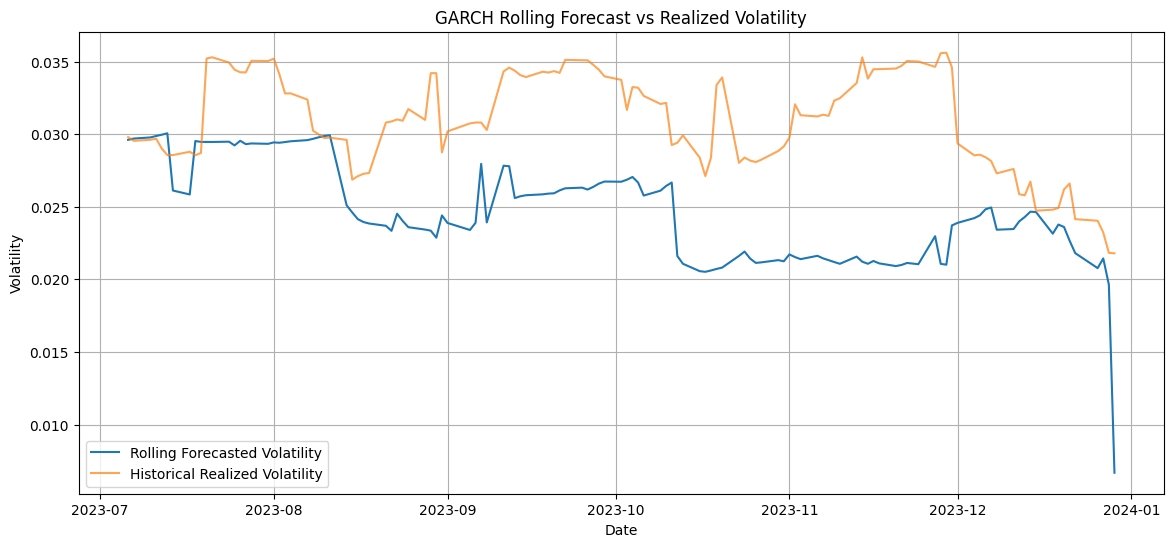

In [71]:
plt.figure(figsize=(14,6))
plt.plot(forecast_vol_series, label='Rolling Forecasted Volatility')
plt.plot(realized_vol, label='Historical Realized Volatility', alpha=0.7)
plt.title("GARCH Rolling Forecast vs Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

Future work can involve incorporating asymmetric models into our volatility clustering/forecasting (such as GJR-GARCH or EGARCH - which handle volatility spikes better than the traditional GARCH model), as well as potentially adding explanatory power using exogenous or external inputs, like macroeconomic indicators or public sentiment.